In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from math import sqrt
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

sns.set_style('white')

In [2]:
# read data
year = 2018
ticker = 'IFM'

col_names=['TIME', 'X', 'Y', 'Z'] 

df_2018 = pd.read_csv(os.path.join(f'../data/index/{year}/{ticker}.csv'), index_col=0, encoding='gbk')
df_2018.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open_interest']

df_2018.rename_axis("type", axis='index', inplace=True)

year = 2019

df_2019 = pd.read_csv(os.path.join(f'../data/index/{year}/{ticker}.csv'), index_col=0, encoding='gbk')
df_2019.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open_interest']

df_2019.rename_axis("type", axis='index', inplace=True)

year = 2020

df_2020 = pd.read_csv(os.path.join(f'../data/index/{year}/{ticker}.csv'), index_col=0, encoding='gbk')
df_2020.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open_interest']

df_2020.rename_axis("type", axis='index', inplace=True)


df = pd.concat([df_2018, df_2019, df_2020])
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)

df['date'] = df.time.dt.date.astype(str)
# df = df.iloc[0:48000, :]
df.drop(columns=['type', 'volume', 'turnover', 'open_interest'], inplace = True)
df

,code,time,open,high,low,close,date
0,IF1801,2018-01-02 09:31:00,4051.6,4060.4,4051.6,4060.0,2018-01-02
1,IF1801,2018-01-02 09:32:00,4060.0,4062.2,4058.6,4060.0,2018-01-02
2,IF1801,2018-01-02 09:33:00,4059.8,4065.8,4059.8,4062.8,2018-01-02
3,IF1801,2018-01-02 09:34:00,4062.6,4063.0,4060.0,4062.6,2018-01-02
4,IF1801,2018-01-02 09:35:00,4062.8,4070.8,4062.4,4070.0,2018-01-02
...,...,...,...,...,...,...,...
175195,IF2101,2020-12-31 14:56:00,5217.8,5218.4,5216.4,5217.8,2020-12-31
175196,IF2101,2020-12-31 14:57:00,5217.8,5219.8,5216.6,5219.0,2020-12-31
175197,IF2101,2020-12-31 14:58:00,5219.0,5219.0,5215.0,5218.2,2020-12-31
175198,IF2101,2020-12-31 14:59:00,5218.2,5221.6,5216.8,5220.4,2020-12-31


算出 period 为 5， 30， 240 的 Hull Moving Average

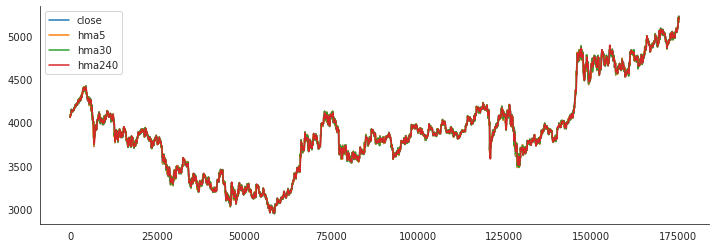

In [3]:
def calculate_hull_moving_average(df, period):

    df['window_t_ewm'] = df['close'].ewm(span=period).mean()
    df['window_half_ewm'] = df['close'].ewm(span=period/2).mean()
    df['diff']=df['window_half_ewm'] * 2 - df['window_t_ewm']
    
    df[f'hma{period}']=df['diff'].ewm(span=int(math.sqrt(period))).mean()
    
    irrelevant_col = ['window_t_ewm', 'window_half_ewm', 'diff']
    df.drop(columns=irrelevant_col, inplace = True)
    
calculate_hull_moving_average(df, 5)
calculate_hull_moving_average(df, 30)
calculate_hull_moving_average(df, 240)

df[['close', 'hma5', 'hma30', 'hma240']].plot(grid=False, figsize=(12,4))
sns.despine()

根据均线计算 Local Min 和 Local Max

In [4]:
def calculate_local_min_max(df, period):
    df['moving_average'] = df[f'hma{period}']
    df['ma_after'] = df['moving_average'].shift(1)
    df['ma_before'] = df['moving_average'].shift(-1)

    df['ma_before'] = df['ma_before'].fillna(df[f'hma{period}'])
    df['ma_after'] = df['ma_after'].fillna(df[f'hma{period}'])

    df["local_min"] = ((df["moving_average"] < df["ma_before"]) & (df["moving_average"] < df["ma_after"]) )
    df["local_max"] = ((df["moving_average"] > df["ma_before"]) & (df["moving_average"] > df["ma_after"]) )

calculate_local_min_max(df, 30)

画出均线每一次上升和下降阶段的时间跨度和价格跨度的散点图

<AxesSubplot:xlabel='time_diff', ylabel='amount_diff'>

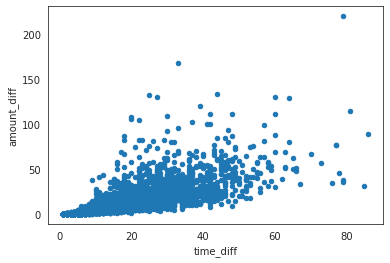

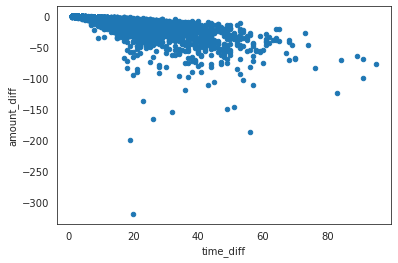

In [5]:
df_extrema = df.loc[ df["local_min"] | df["local_max"] ].copy()

# Use the index as the difference in trade time
df_extrema['time_minute']= df_extrema.index
df_extrema['time_minute_shift']=df_extrema['time_minute'].shift(1)
df_extrema['time_minute_shift']=df_extrema['time_minute_shift'].fillna(0)

df_extrema['time_diff'] = df_extrema['time_minute'] - df_extrema['time_minute_shift']
# Fill the first amount diff with (current price) - (open price of first minute)
df_extrema['amount_diff'] = df_extrema['moving_average'] - df_extrema['moving_average'].shift(1).fillna(df['open'].iloc[0])

df_min = df_extrema[df_extrema["local_min"]==True]
df_max = df_extrema[df_extrema["local_max"]==True]

df_max.plot.scatter(x='time_diff', y='amount_diff')
df_min.plot.scatter(x='time_diff', y='amount_diff')

对散点图进行 OLS 回归

                            OLS Regression Results                            
Dep. Variable:            amount_diff   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 1.070e+04
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:43:46   Log-Likelihood:                -25466.
No. Observations:                7132   AIC:                         5.094e+04
Df Residuals:                    7130   BIC:                         5.095e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3953      0.148    -22.868      0.0

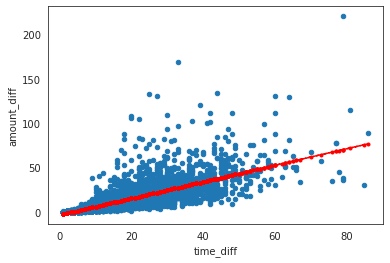

In [6]:
x = df_max['time_diff']
x2 = sm.add_constant(x)
y = df_max['amount_diff']
est = sm.OLS(y, x2)
results = est.fit()
y_fitted = results.fittedvalues

df_max.plot.scatter(x='time_diff', y='amount_diff')
plt.plot(x, y_fitted, 'r--.')

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            amount_diff   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     8169.
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:43:46   Log-Likelihood:                -25945.
No. Observations:                7131   AIC:                         5.189e+04
Df Residuals:                    7129   BIC:                         5.191e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8777      0.159     18.072      0.0

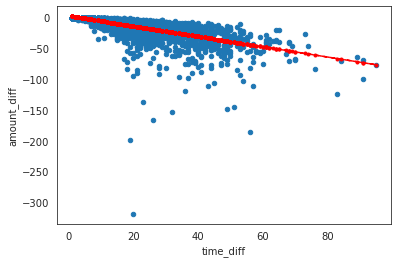

In [7]:
x = df_min['time_diff']
x2 = sm.add_constant(x)
y = df_min['amount_diff']
est = sm.OLS(y, x2)
results = est.fit()
y_fitted = results.fittedvalues

df_min.plot.scatter(x='time_diff', y='amount_diff')
plt.plot(x, y_fitted, 'r--.')

print(results.summary())

Increasing Trend Time Distribution Mean： 12.011777902411666
STD： 11.323923585010874
Count： 7132
Stardard Error: 0.13408841672419947
Skewness： 1.6968695967687908
Kurtosis： 3.8359577968813423


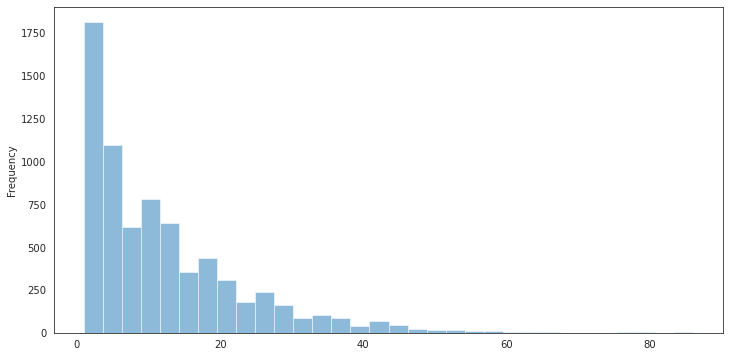

In [8]:
print("Increasing Trend Time Distribution Mean：", df_max['time_diff'].mean())

std = df_max['time_diff'].std()
print("STD：", std)
print("Count：", df_max['time_diff'].count())
print("Stardard Error:", std / sqrt(df_max['time_diff'].count()))
print("Skewness：", df_max['time_diff'].skew())
print("Kurtosis：", df_max['time_diff'].kurtosis())

increasing_trend_time_distribution = df_max['time_diff'].plot.hist(bins=32, alpha=0.5, figsize=(12, 6) )

Increasing Trend Amount Distribution Mean： 7.779811675251395
STD： 13.599717885213927
Count： 7132
Stardard Error: 0.16103646633026644
Skewness： 4.018983840715216
Kurtosis： 26.649118110102723


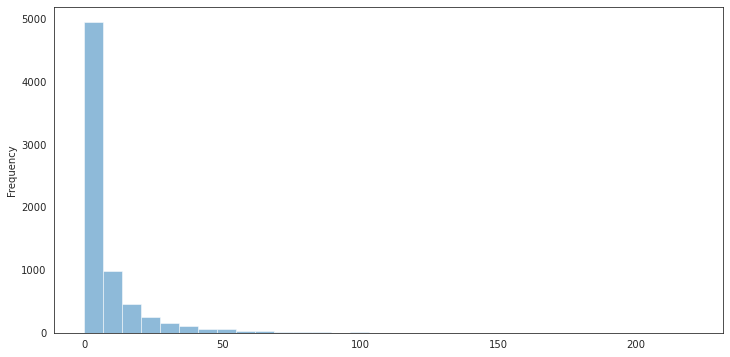

In [9]:
print("Increasing Trend Amount Distribution Mean：", df_max['amount_diff'].mean())

std = df_max['amount_diff'].std()
print("STD：", std)
print("Count：", df_max['amount_diff'].count())
print("Stardard Error:", std / sqrt(df_max['amount_diff'].count()))
print("Skewness：", df_max['amount_diff'].skew())
print("Kurtosis：", df_max['amount_diff'].kurtosis())

increasing_trend_time_distribution = df_max['amount_diff'].plot.hist(bins=32, alpha=0.5, figsize=(12, 6) )

Decreasing Trend Time Distribution Mean： 12.55335857523489
STD： 11.784283916048665
Count： 7131
Stardard Error: 0.13954940177928893
Skewness： 1.618299737305779
Kurtosis： 3.5135998097187535


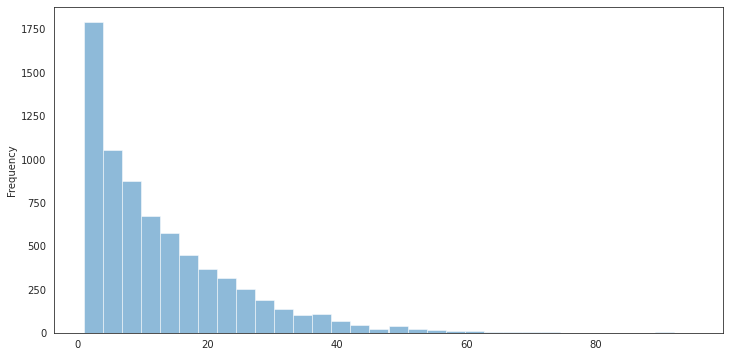

In [10]:
print("Decreasing Trend Time Distribution Mean：", df_min['time_diff'].mean())

std = df_min['time_diff'].std()
print("STD：", std)
print("Count：", df_min['time_diff'].count())
print("Stardard Error:", std / sqrt(df_min['time_diff'].count()))
print("Skewness：", df_min['time_diff'].skew())
print("Kurtosis：", df_min['time_diff'].kurtosis())

decreasing_trend_time_distribution = df_min['time_diff'].plot.hist(bins=32, alpha=0.5, figsize=(12, 6) )

Increasing Trend Time Distribution Mean： -7.615560775990316
STD： 13.47991422934511
Count： 7131
Stardard Error: 0.1596290432360851
Skewness： -5.592805403281478
Kurtosis： 67.18286010490327


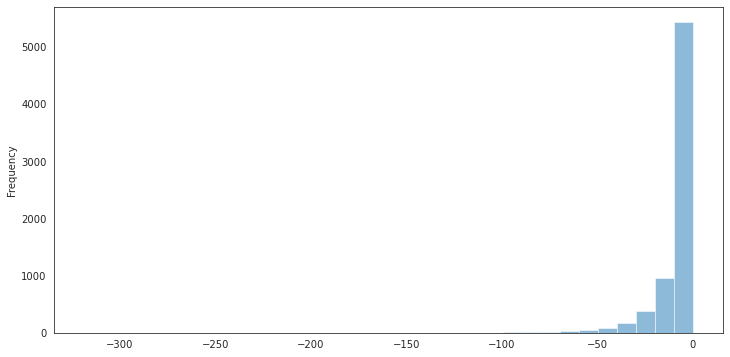

In [11]:
print("Increasing Trend Time Distribution Mean：", df_min['amount_diff'].mean())

std = df_min['amount_diff'].std()
print("STD：", std)
print("Count：", df_min['amount_diff'].count())
print("Stardard Error:", std / sqrt(df_min['amount_diff'].count()))
print("Skewness：", df_min['amount_diff'].skew())
print("Kurtosis：", df_min['amount_diff'].kurtosis())

decreasing_trend_amount_distribution = df_min['amount_diff'].plot.hist(bins=32, alpha=0.5, figsize=(12, 6) )